In [1]:
import os
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

# mne
import mne
from mne.io import read_raw_egi

# będziemy tym razem wczytywać dane (epoki i ica) z dysku:
from mne.preprocessing.ica import read_ica
from mne.epochs import read_epochs

# mypy
from mypy.chans import correct_egi_channel_names
from mypy.events import get_events_from_din
from mypy.viz import set_3d_axes_equal

%matplotlib

Using matplotlib backend: Qt4Agg


In [2]:
# nazwa pliku, z którego korzystamy:
base_dir = r'C:\Users\Ola\Dropbox\CAT N170\EEG'
file_name = r'CAT312 20131209 2056002.raw'

# usuwamy koncówkę .raw - będziemy doklejać -epo.fif albo -ica.fif
file_name = file_name.replace('.raw', '')
print(file_name)

CAT312 20131209 2056002


In [3]:
# get ica and epochs:
epochs_filepath = op.join(base_dir, 'epochs', file_name + '-epo.fif')
epochs = read_epochs(epochs_filepath, proj=False) # proj=False aby nie włączał nam automatycznie referencji do średniej

ica = read_ica(op.join(base_dir, 'ica', file_name + '-ica.fif'))

Reading C:\Users\Ola\Dropbox\CAT N170\EEG\epochs\CAT312 20131209 2056002-epo.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 65)  idle
    Found the data of interest:
        t =    -248.00 ...     752.00 ms (None)
        0 CTF compensation matrices available
386 matching events found
Created an SSP operator (subspace dimension = 1)
386 matching events found
Created an SSP operator (subspace dimension = 1)
Reading C:\Users\Ola\Dropbox\CAT N170\EEG\ica\CAT312 20131209 2056002-ica.fif ...
Isotrak not found
    Read a total of 1 projection items:
        Average EEG reference (1 x 65)  idle
Now restoring ICA solution ...
Ready.


In [4]:
# korzystamy z ica aby wyczyścić dane ze złych komponentów
epochs_clean = ica.apply(epochs.copy())

# interpolujemy złe kanały
epochs_clean.interpolate_bads()

# tworzymy referencję do średniej
epochs_clean.set_eeg_reference()

# i stosujemy ją do danych (przekształcamy dane)
epochs_clean.apply_proj()

# ach, no i wybieramy tylko kanały eeg (kanały z triggerami już dawno nie są nam potrzebne)
epochs_clean.pick_types(eeg=True)

Transforming to ICA space (42 components)
Zeroing out 6 ICA components
Computing interpolation matrix from 64 sensor positions
Interpolating 1 sensors
An average reference projection was already added. The data has been left untouched.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


<ipython-input-4-b7aba9ef56fb>:8: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  epochs_clean.set_eeg_reference()


<EpochsFIF  |  n_events : 386 (all good), tmin : -0.248 (s), tmax : 0.752 (s), baseline : (-0.24799999594688416, 0.0), ~48.2 MB, data loaded,
 'car/0': 65, 'car/180': 65, 'car/90': 65, 'face/0': 64, 'face/180': 62, 'face/90': 65>

### porównanie sygnału przed i po 

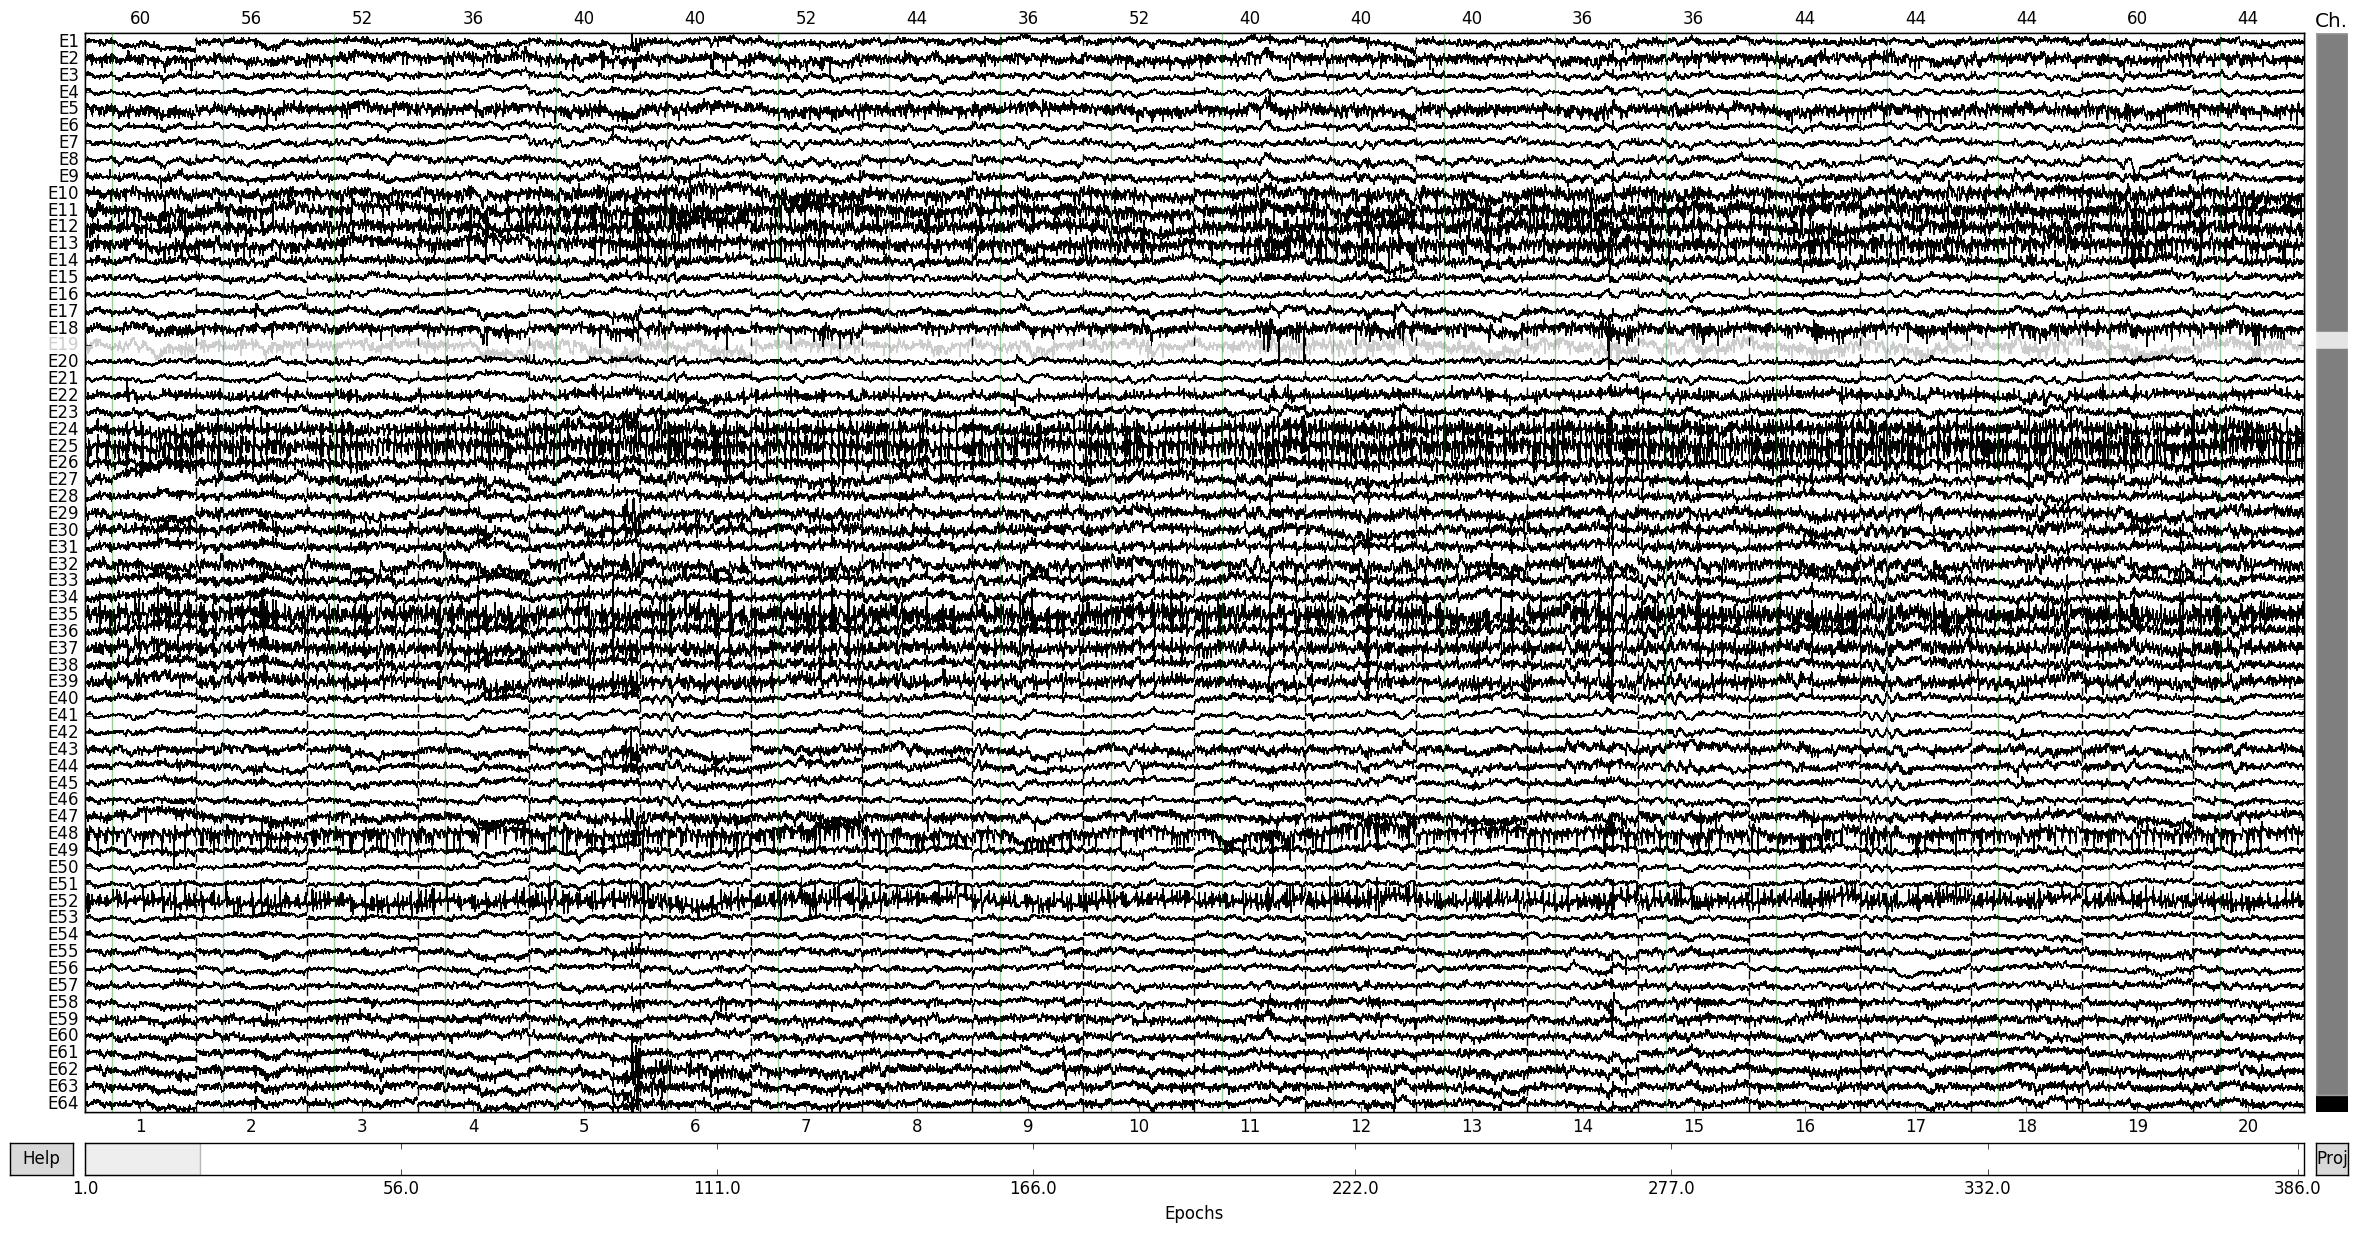

Dropped 0 epochs
Channels marked as bad: ['E19']


In [5]:
epochs.plot(n_channels=64, scalings={'eeg': 10e-5})

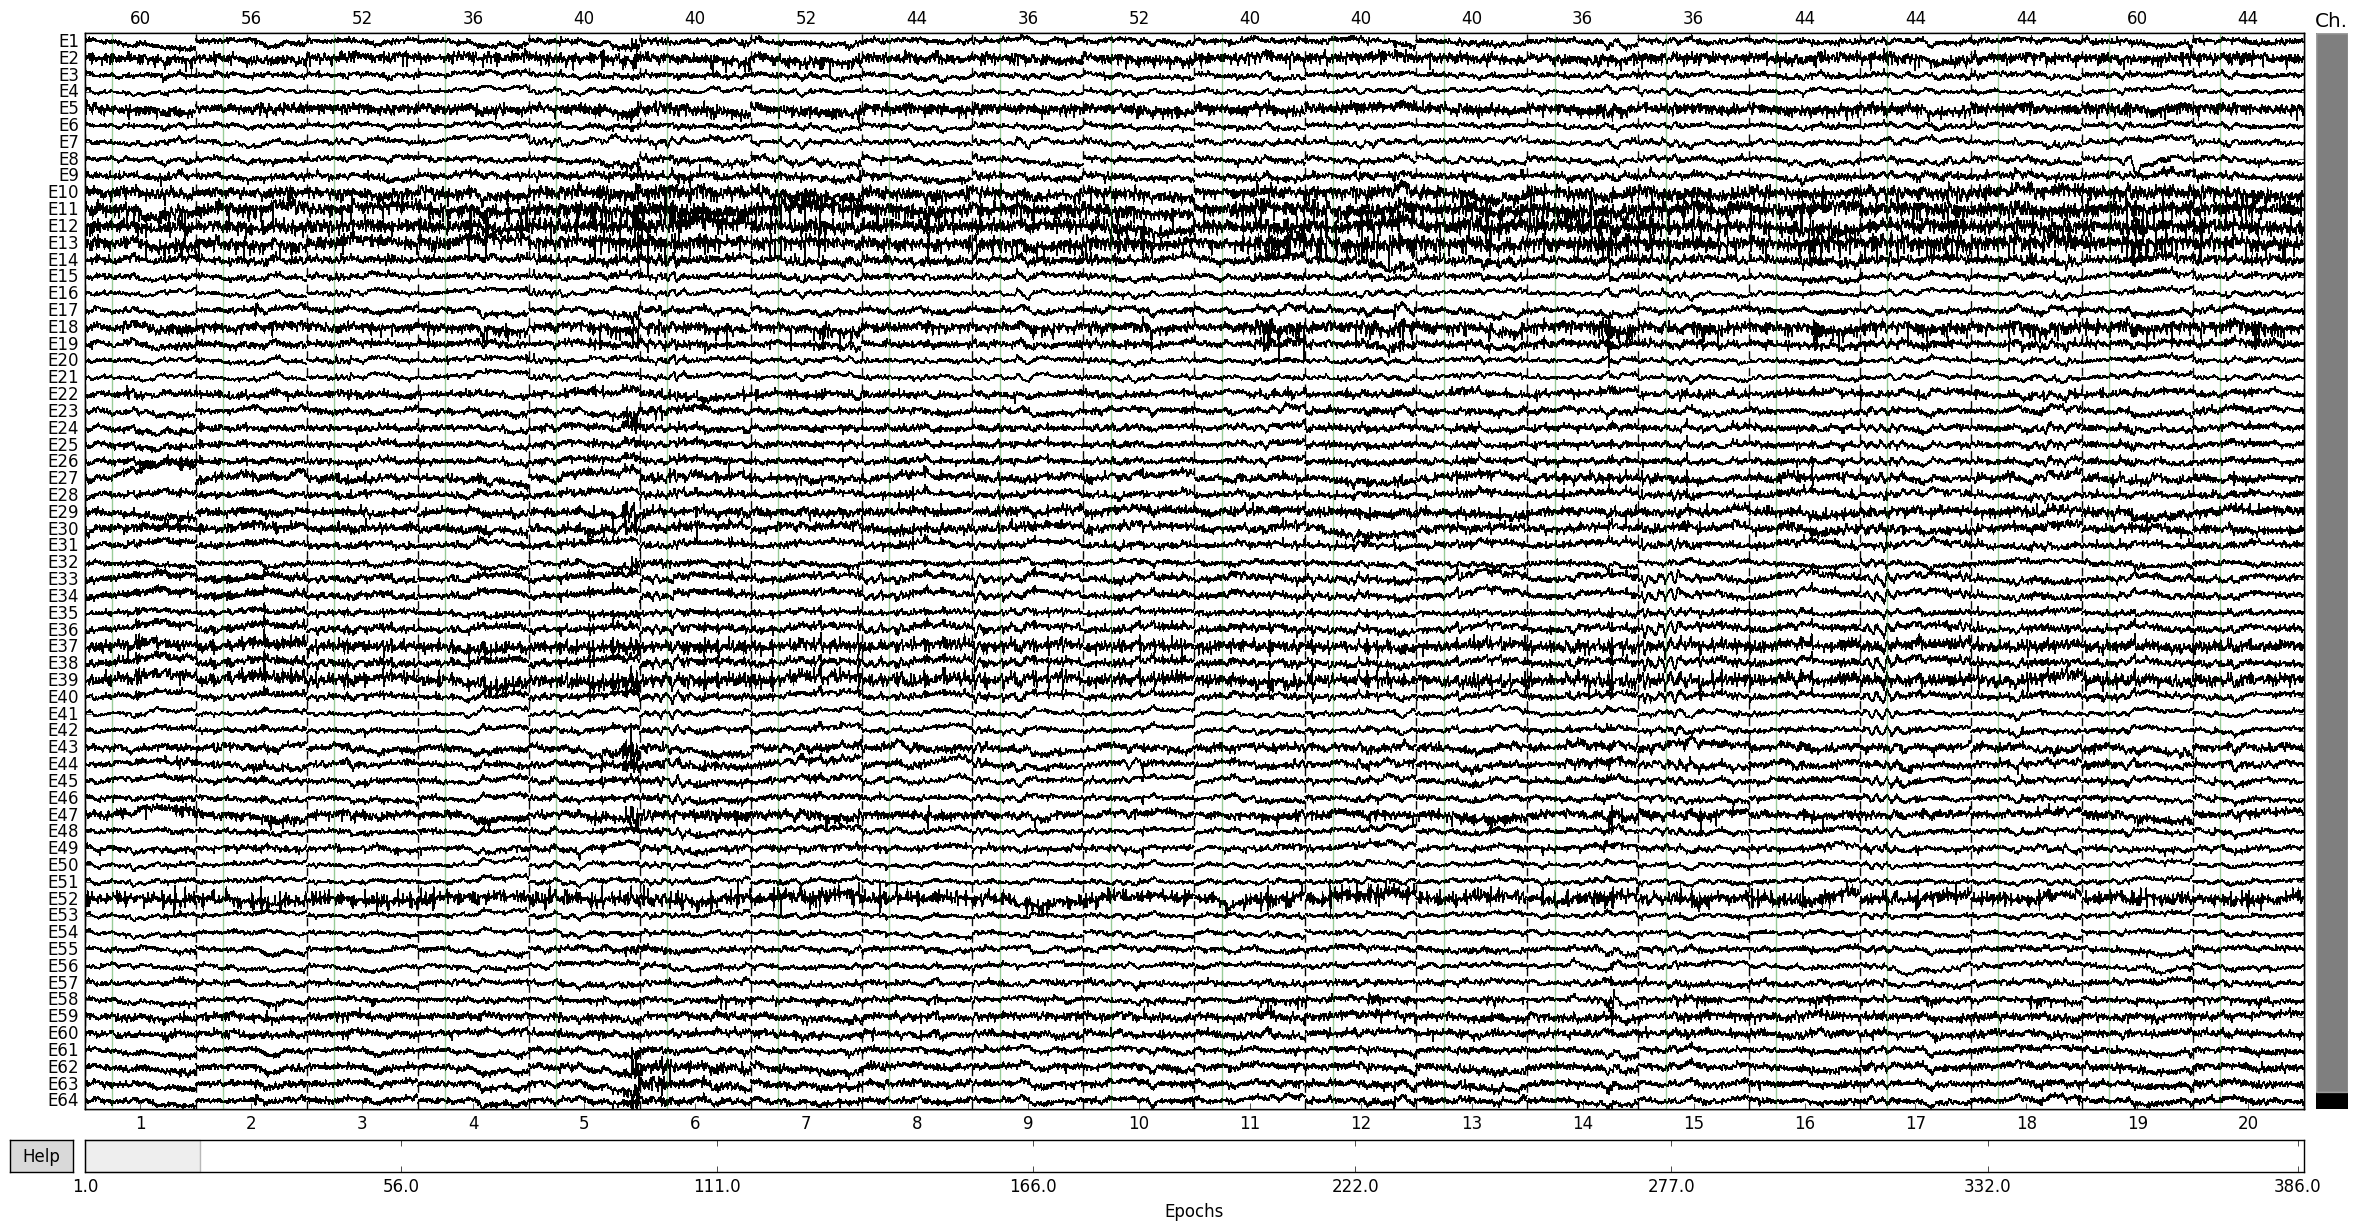

Dropped 0 epochs
Channels marked as bad: []


In [6]:
epochs_clean.plot(n_channels=64, scalings={'eeg': 10e-5})

## Wizualizacja ERPów

In [7]:
# czas na erpy (więcej w dokumencie na githubie)

# tworzymy sobie średnią odpowiedź niezależnie od rodzaju bodźca
all_erp = epochs_clean.average()

# a tak tworzymy sobie ERPa na wszystkie twarze (niezależnie od obrotu):
face_erp = epochs_clean['face'].average()

# a tak gdy chcemy ERPa konkretnie na twarze prezentowane prosto:
face_0_erp = epochs_clean['face/0'].average()

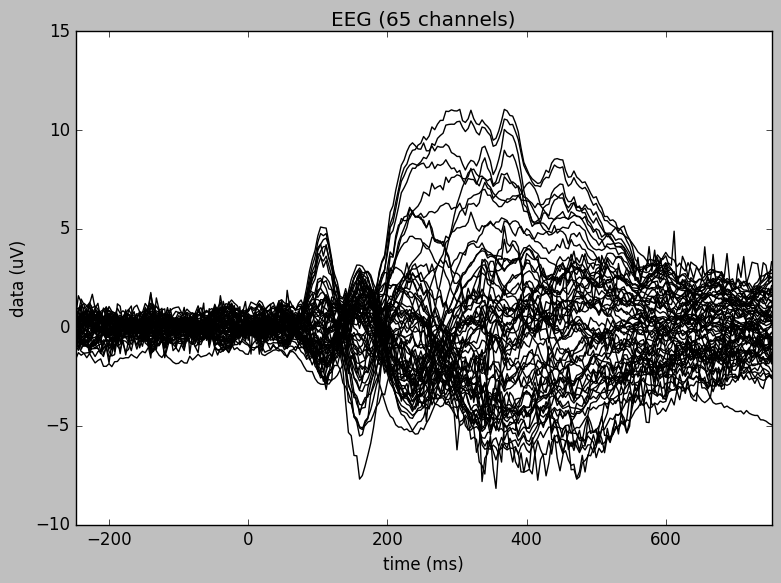

In [8]:
# zobaczmy sobie erpy, wersja czarna
all_erp.plot()

C:\Miniconda3\lib\site-packages\matplotlib\figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


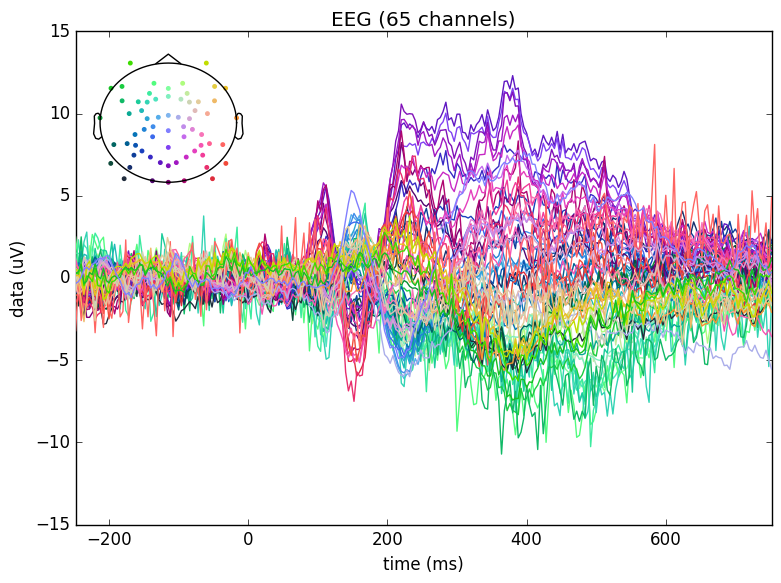

In [10]:
fig = face_0_erp.plot(spatial_colors=True)
fig.set_facecolor('w') # ustawiamy tło na białe
fig                    # aby wykres wyświetlił się też w notebook'u

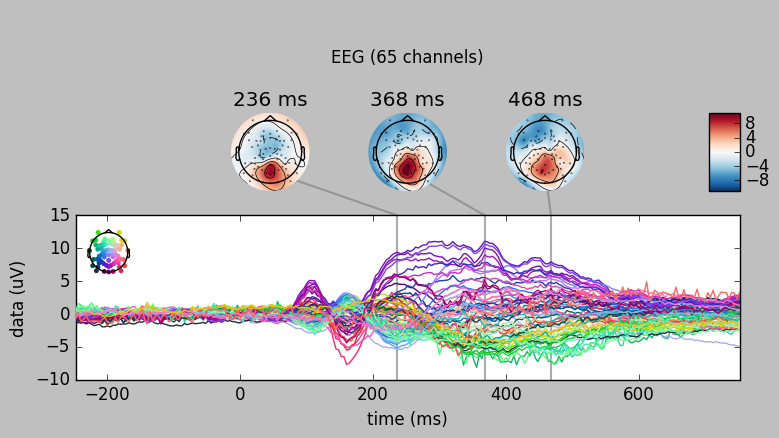

In [12]:
# plot_join pozwala na zestawienie wykresu liniowego i główek, domyślnie sam znajduje punkty czasowe dla główek
all_erp.plot_joint()

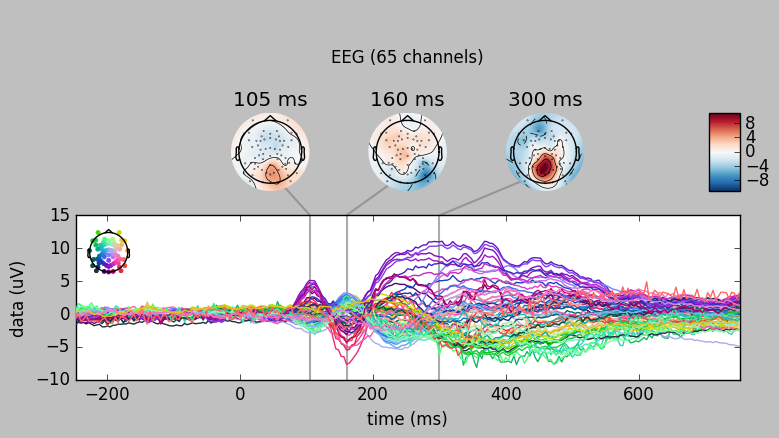

In [14]:
# ale czasem nie wybiera dobrze, więc możemy podać mu czasy sami:
all_erp.plot_joint(times=[0.105, 0.16, 0.3])

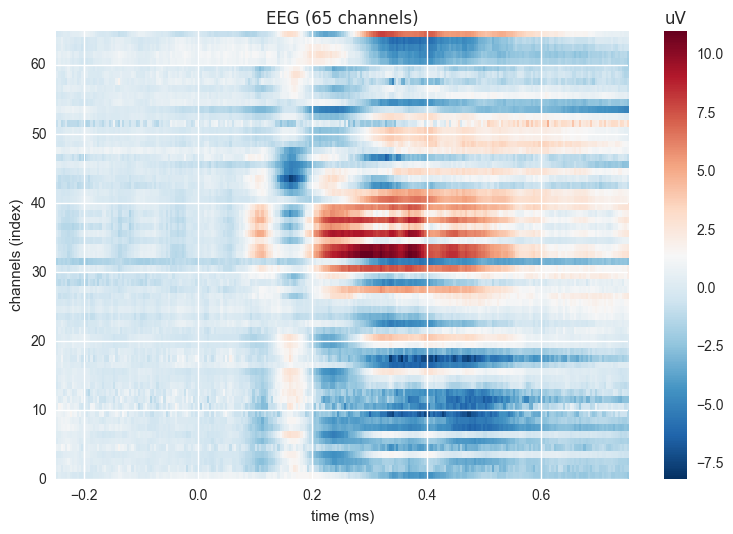

In [34]:
# erp w macierzy kanały vs czas
all_erp.plot_image()

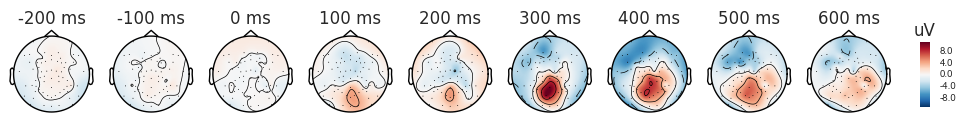

In [36]:
# główki, główki, główki!
all_erp.plot_topomap(times=np.arange(-0.2, 0.65, 0.1))

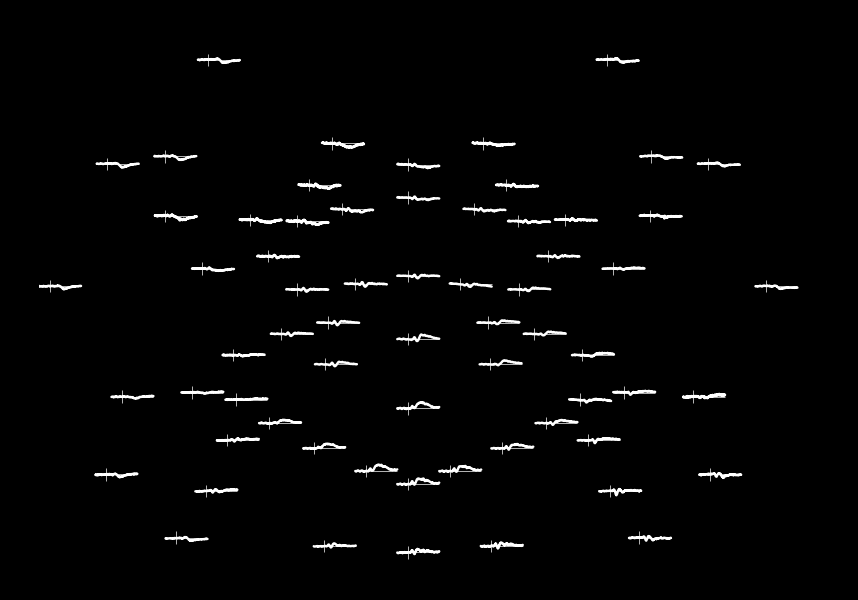

In [37]:
# głowo-erpo plot (w trybie interaktywnym możecie sobie poklikać na wykresy erpów by wam wyskoczyły w oddzielnym oknie)
all_erp.plot_topo()

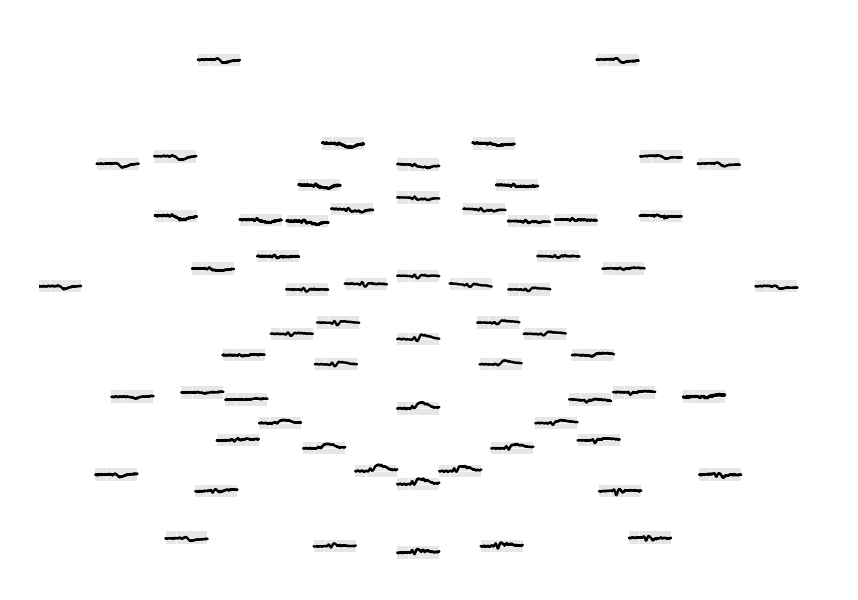

In [38]:
all_erp.plot_topo(fig_facecolor='w', axis_facecolor=[0.9, 0.9, 0.9], font_color='red', color='k')

## Przepraszam, szukam takiego czubka...
Najprostszą metodą analizy ERPów jest porównywanie amplitudy bądź latencji (czasu) dla czubków charakterystycznych komponentów ERPa. Np. chcemy dowiedzieć się czy potencjał P100 albo N170 przy prezentacji twarzy jest większy niż dla prezentacji samochodów. Zanim będziemy mogli odpowiedieć na to pytanie musimy znaleźć te czubki - ale jak to zrobić?! <jejku-rety-jejku>
Najłatwiej będzie Wam skorzystać z mojego poszukiwacza czubków - `Peakachu`. `Peakachu` sam jest czubkiem, a wiadomo, że ciągnie swój do swego, więc łatwiej mu znajdywać czubki niż zwykłemu śmiertelnie poważnemu śmiertelnikowi.
`Peakachu` znajduje się w `mypy` w podmodule `chans`.

In [15]:
from mypy.chans import Peakachu

Powiedzmy, że interesuje nas peak N170 (negatywny, w okolicach 170 ms po bodźcu), tworzymy więc Peakachu, który będzie poszukiwał takiego załamka tak:
```python
pika = Peakachu(mode='N170')
```
Peakachu sprawdza wszystkie elektrody w poszukiwaniu czubka i wybiera kilka dla których czubek będzie najsilniejszy. Ile to będzie elektrod - to zależy od nas, do tego służy argument `n_channels`. Np. gdy chcemy wybierać 6 kanałów z najsilniejszym czubkiem, robimy to tak:
```python
pika = Peakachu(mode='N170', n_channels=6)
```
Ok, zróbmy tak więc:

In [16]:
pika = Peakachu(mode='N170', n_channels=6)

Ok, teraz aby polecić naszemu `pika` aby wyszukał dla naszych epok czubki używamy metody `fit` i podajemy jej naszego erpa.
W ten sposób nasz `pika` staje się dopasowany do naszych danych - wie, na których kanałach znajdują się najsilniejsze czubki.

In [17]:
pika.fit(all_erp)

Zobaczmy gdzie `pika` znalazł czubki, korzystamy do tego z metody `plot_topomap`: 

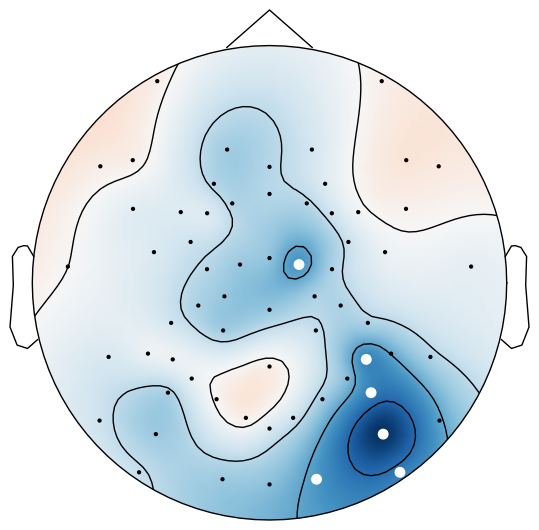

In [18]:
pika.plot_topomap()

Mogło się zdarzyć tak, że `pika` znalazł nam kanały, które nie sąsiadują ze sobą wszystkie - zwykle nie chcemy takiego zachowania, dlatego dalej zobaczycie jak je korygować. Na razie jednak nie przejmujmy się tym.
`Peakachu` jest bardzo fajny, bo poza tym, że tak jak jego brat Pikachu, potrafi razić wroga elektrycznością, to teraz, jak już wie gdzie szukać pików, pozwala nam wyplotować średniego erpa dla elektrod, które wybrał - w dodadtku z podziałem na warunki!
Korzystamy do tego z metody `plot_erp`:

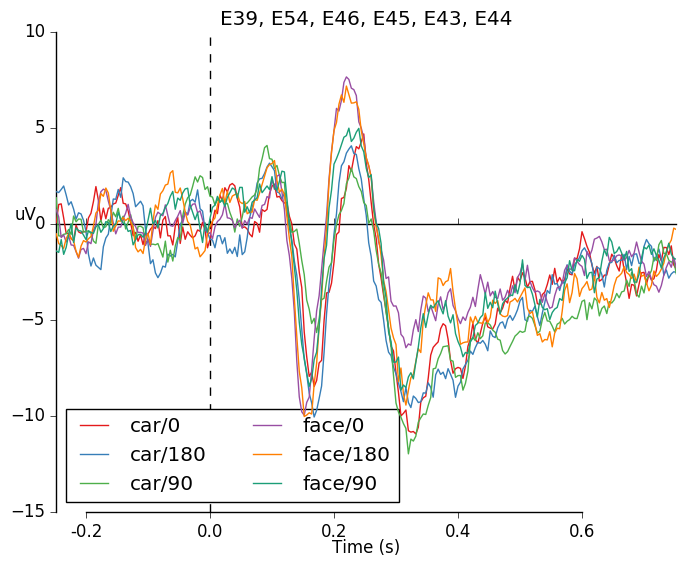

In [19]:
pika.plot_erp(epochs)

Aby zmniejszyć nieco harmider wybieramy tylko bodźce do góry nogami: 

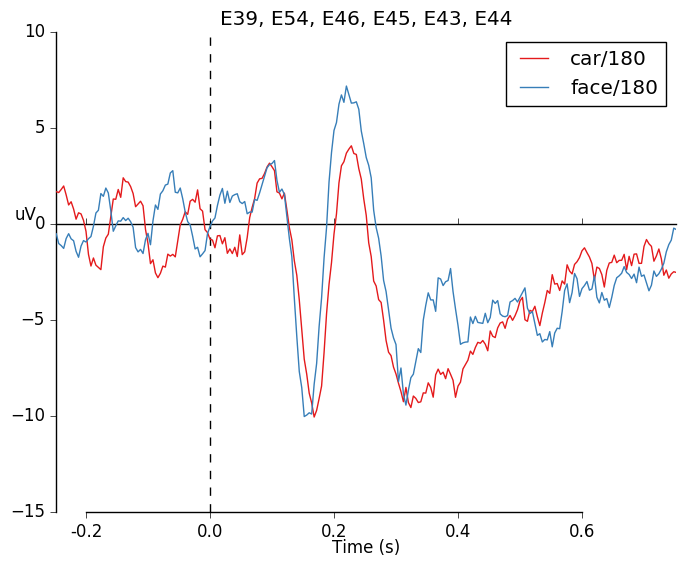

In [20]:
pika.plot_erp(epochs['180'])

Dopasowanie `pika` do danych to połowa sukcesu - teraz chcemy wyciągnąć za jego pomocą z danych wartości peaków i ich latencję. Korzystamy z metody `transform`: 

In [21]:
peak_val, peak_lat = pika.transform(epochs)

C:\Miniconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


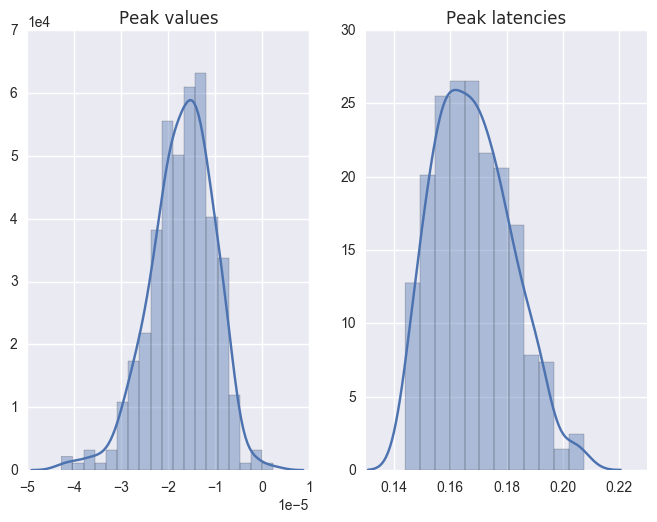

In [22]:
# czas na elegancki wykresik rozkładu wartości peaku oraz latencji

# seaborn ładnie rysuje, więc zapraszamy go do zabawy
import seaborn as sns

# tworzymy wykres i dwa podwykresy w nim (dwie kolumny wykresów)
fig, axes = plt.subplots(ncols=2)

# axes to teraz lista podwykresów: axes[0] to pierwszy, axes[1] to drugi

# korzystamy z funkcji do rysowania rozkładów seaborna, podajemy dane i pierwszy wykres
sns.distplot(peak_val, ax=axes[0])
# ustawiamy tytuł tego wykresu (set_title to metoda podwykresu)
axes[0].set_title('Peak values')

# dla pierwszego podwykresu chcemy mieć sklaę naukową `style='sci'`
# dla osi x `axes='x'` jeżeli wartości wykraczają poza 10**-2 bądź 10**2
# `scilimits=(-2, 2)
axes[0].ticklabel_format(style='sci', axes='x', scilimits=(-2, 2))

# czas na drugi podwykres
sns.distplot(peak_lat, hist=True, ax=axes[1])
axes[1].set_title('Peak latencies')

fig # to jest tylko po to aby wykres pokazał się w notebook'u

Chcemy jednak patrzeć nie na wszystkie peaki i latencje, ale porównać je między warunkami (np. twarz vs samochód). Poniżej oddzielnie korzystamy z pika dla epoch z warunku `'face/0'` oraz `'car/0'`: 

In [23]:
peak_val_face, peak_lat_face = pika.transform(epochs['face/0'])
peak_val_car, peak_lat_car = pika.transform(epochs['car/0'])

C:\Miniconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


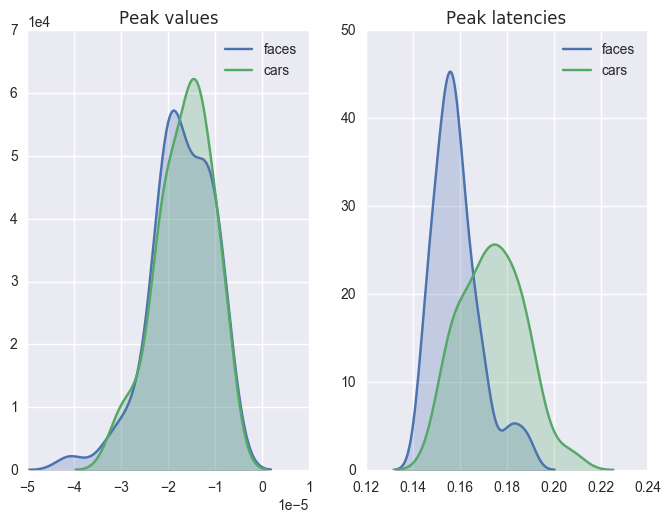

In [24]:
# znów wykresy!

fig, axes = plt.subplots(ncols=2)

# teraz dajemy trochę więcej parametrów do funkcji distplot:
# hist=False to prośba aby histogram nie był wyświetlany
# kde_kws to argument, który podaje argumenty do funkcji, która rysuje kde tzn. kernel density estimate
# kde_kws dostaje od nas dict(shade=True) tzn. słownik argumentów, a faktycznie jednego argumentu:
# shade=True - co funkcja rysująca kde zrozumie jako "rysuj śliczny cienik, funkcyjko!"
# (ten cien to zakolorowanie pod linią rozkładu)
# wreszcie label='faces' itp. to etykiety dla kolejnych rozkładów, aby mieć ładną legendę od razu
sns.distplot(peak_val_face, hist=False, kde_kws=dict(shade=True), ax=axes[0], label='faces')
sns.distplot(peak_val_car, hist=False, kde_kws=dict(shade=True), ax=axes[0], label='cars')

# tak jak wcześniej: tytuły, naukowa notacja (* 1e-5)
axes[0].set_title('Peak values')
axes[0].ticklabel_format(style='sci', axes='x', scilimits=(-2, 2))

# podwykres dla latencji
sns.distplot(peak_lat_face, hist=False, kde_kws=dict(shade=True), ax=axes[1], label='faces')
sns.distplot(peak_lat_car, hist=False, kde_kws=dict(shade=True), ax=axes[1], label='cars')
axes[1].set_title('Peak latencies')

fig

## Test t

In [25]:
from scipy.stats import ttest_ind
test1 = ttest_ind(peak_val_face, peak_val_car)
test2 = ttest_ind(peak_lat_face, peak_lat_car)

print(test1)
print(test2)

Ttest_indResult(statistic=-0.51042104885647577, pvalue=0.61064254043028443)
Ttest_indResult(statistic=-7.2736706706480829, pvalue=3.1864361407503217e-11)


In [26]:
from mypy.stats import format_pvalue

df = len(peak_val_face) + len(peak_val_car) - 2

for test in [test1, test2]:
    print('t ({}) = {:.3f}; {}'.format(df, test.statistic, format_pvalue(test.pvalue)))

t (127) = -0.510; p = 0.611
t (127) = -7.274; p < 1e-10


Przy teście t, jak w większości najczęściej używanych testów parametrycznych, zakładamy że dane mają rozkład normalny.
Tego nikt w zasadzie nie sprawdza w neuronauce, bo neuronaukowcy są
`random.sample(['leniwi', 'optymistyczni', 'niedouczeni', 'niegodni zaufania'])`
ale my sprawdzimy!  
Szafirowy Wilku, przybywaj!  
<img src=http://t01.deviantart.net/YncRlGV8wA3r9bIddvyVzgc1ySg=/300x200/filters:fixed_height(100,100):origin()/pre01/5b72/th/pre/f/2013/136/7/c/sapphirewolfgod_by_lilly_nila-d65fu1a.png align='left'>

In [27]:
from scipy.stats import shapiro

W_statistic, p_value = shapiro(peak_val_face)
print('W = {}; {}'.format(W_statistic, format_pvalue(p_value)))

W = 0.9424391984939575; p = 0.005


W tym wypadku dane nie są normalne (są szalone!), więc moglibyśmy użyć np. `scipy.stats.mannwhitneyu` (*U Mann'a-Whitney'a*), przy czym:
* tak jak już wspominałem wyżej, w neuro nikt się tak nie patyczkuje i wyszlibyście na nadgorliwych wariatów (czy statystycznych nazistów) :)
* test t jest stosunkowo odporny na pewne odstępstwa od normalności danych, także nie wychodzimy tu najgorzej (spójrzcie na rozkłady wyżej - są tylko trochę szalone)
* tutaj robimy test wewnątrz jednej osoby, natomiast najczęściej robi się testy dla wielu osób. Wtedy z każdej osoby mamy średnią wartość peaku (czy latencji) i pod warunkiem, że każda ze średnich pochodzi z wielu triali (tzn. co najmniej kilkudziesięciu, najlepiej >= 50) to centralne twierdzenie graniczne przychodzi nam z pomocą i kojąco śpiewa że rozkład średnich będzie normalny
* i wreszcie - w neuro często robi się testy nieparametryczne, a konkretnie - testy permutacyjne, które mają w nosie jaki jest rozkład danych (co prawda mają też słabszą moc niż testy parametryczne - ale tylko wtedy gdy założenia testów parametrycznych są spełnione)

Porównania statystyczne dla wielu osób oraz testy permutacyjne będziemy jeszcze przerabiać (a nawet zahaczymy o masowe przeprowadzanie testów i korektę na wielokrotne porównania).

In [28]:
from scipy.stats import mannwhitneyu

# ZADANIE
# dla danych które nie są normalne - sprawdźcie jak wychodzi mann-whitney u test
# podpowiedź: łatwo sprawdzicie dokumentację dla powyższej funkcji trickiem z shift-tab'em
# ale prawdziwy programista nie rozstaje się z googlem - możecie sobie znaleźć dokumentację
# w sieci, pogooglujcie np. scipy.stats.mannwhitneyu

Zakładaliśmy, że nasze dane mają jednorodną wariancję, ale możemy to przecież sprawdzić. Użyjemy do tego testu Levene'a (bo i tak zakładamy, że dane mają rozkład normalny):

In [29]:
from scipy.stats import levene

levene_test = levene(peak_lat_face, peak_lat_car)
print(levene_test)

LeveneResult(statistic=6.8958114742912811, pvalue=0.0097018223412408157)


In [30]:
# jeżeli pvalue jest wystarczająco niskie (np < 0.05) uznajemy że dane nie mają jednorodnej wariancji -
# wtedy musimy zastosować test Welcha, robimy to tak:

if levene_test.pvalue < 0.05:
    this_test = ttest_ind(peak_lat_face, peak_lat_car, equal_var=False)
    
    # wyświetlamy wynik
    print('t ({}) = {:.3f}; {}'.format(df, this_test.statistic, format_pvalue(this_test.pvalue)))
else:
    print("Wariancja jednorodna jak dwie krople wody")

t (127) = -7.288; p < 1e-10


### Zadania
* sprawdź założenia (normalność rozkładu, jednorodność wariancji) dla obu testów (latencji i amplitud)
* wykorzystaj Peakachu w trybie P100 (`mode='P100'`) - powtórz kroki dla N170 wliczając testy statystyczne
* możesz też spróbować trybu P300 jeżeli wygląda na to, że dana osoba ma wyraźne P300 (nie wszystkie muszą mieć - to nie jest klasyczne zadanie na P300)

### jeżeli chcemy nie mieć problemu z niesąsiadującymi kanałami
Możemy utworzyć i podać `Peakachu` informację o sąsiedztwie kanałów (które kanały sąsiadują z którymi).

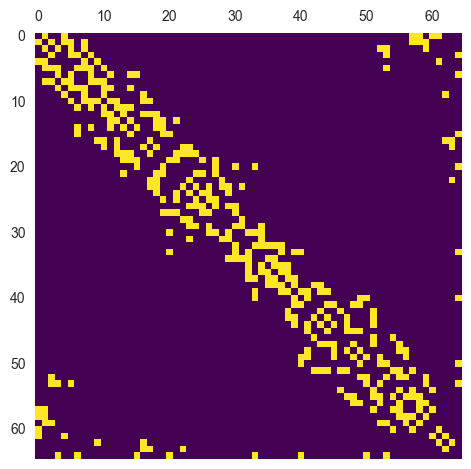

In [31]:
from mypy.cluster import plot_neighbours, construct_adjacency_matrix

# tworzymy macierz sąsiedztwa czyli taką krzyżówkę logiczną - dla każdej
# pary kanałów zakoloruj kratkę jeżeli sąsiadują ze sobą w przestrzeni
adj = construct_adjacency_matrix(epochs_clean.ch_names, 'EGI64')

# obrazek
plt.matshow(adj, cmap='viridis')
plt.grid('off') # seaborn włącza nam domyślnie siatkę, a my tutaj wyłączamy, ha!
plt.gcf() # to tylko po to aby obrazek wyświetlił się też poniżej

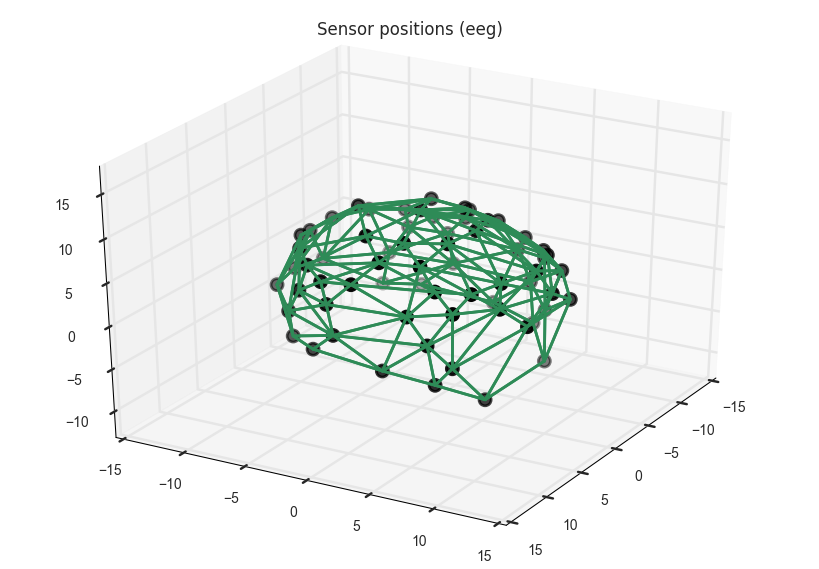

In [32]:
# narysujmy sobie graf sąsiedztwa
plot_neighbours(epochs_clean.info, adj, color='seagreen')

ax = plt.gca()              # weż aktywny podwykres (gca - od "get current axes")
ax.view_init(30, 30)        # ustaw kąt kamery na 'trochę z boku'
ax.patch.set_facecolor('w') # ustaw kolor tła podwykresu na biały (seaborn chyba to zmienia, że jest szare...)
plt.gcf()                   # aby niżej też wyskoczył wykres musi być ostatnim elementem w komórce (gcf = get current figure)

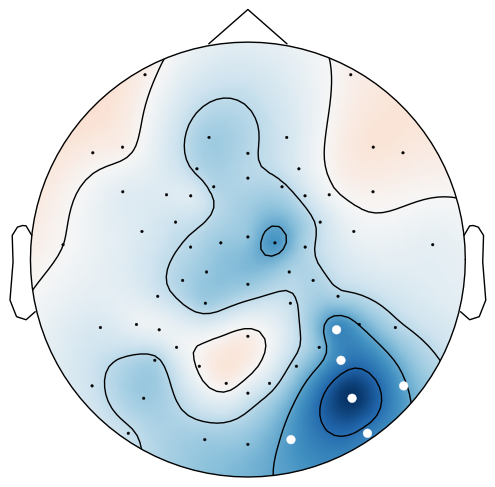

In [33]:
# podajemy peakachu argument connectivity i do niego naszą zmienną adj, czyli macierz sąsiedztwa
pkch = Peakachu(mode='N170', n_channels=6, connectivity=adj)

# teraz nasz drogi pika będzie szukał SĄSIADUJĄCYCH kanałów z najsilniejszymi peakami
pkch.fit(all_erp)
pkch.plot_topomap()

## inne

* ćwiczenia na `if`y
* ćwiczenia na pętle
* za pomocą pętli robimy erp'a z coraz większej liczby triali - 10, 20, 30, 40...
* rysujemy te erpy na jednym wykresie
* a teraz po 100 razy robimy erpa z 10, 20, 30 i 40 epok - na 4 oddzielnych podwykresach

[8, 115, 131, 139, 170, 207, 255]
